In [1]:
import pandas as pd

In [2]:
#load data
df=pd.read_csv('final_cleaned.csv')

In [3]:
#view
df.head()

,Unnamed: 0,Review Text,Rating
0,0,Not great speakers,3.0
1,1,Great little gagit,4.0
2,2,Awesome 👏🏽,5.0
3,3,Love my Echo,5.0
4,4,Great device,5.0


In [4]:
#rating class distribution
df['Rating'].value_counts().sort_index()

Rating
1.0     8669
2.0     4283
3.0     7786
4.0    17541
5.0    47857
Name: count, dtype: int64

In [6]:
import re

# Example: cleaning the review text

def clean_review(text):
    if pd.isnull(text):
        return ""

    # Remove emojis
    text = re.sub(r'[^\w\s,]', '', text.encode('ascii', 'ignore').decode('ascii'))
    
    # Remove special characters and digits (keep letters and basic punctuation if needed)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply to the column
df['Review'] = df['Review Text'].astype(str).apply(clean_review)

# View cleaned data
print(df[['Review Text', 'Review']].head())

          Review Text              Review
0  Not great speakers  not great speakers
1  Great little gagit  great little gagit
2          Awesome 👏🏽             awesome
3        Love my Echo        love my echo
4        Great device        great device


In [7]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


In [9]:
#checking conflicting reviews
from textblob import TextBlob

# Get sentiment polarity for each review (-1 = negative, 1 = positive)
df['Polarity'] = df['Review'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Optional: classify sentiment direction
def classify_sentiment(p):
    if p > 0.2:
        return 'positive'
    elif p < -0.2:
        return 'negative'
    else:
        return 'neutral'

df['Sentiment'] = df['Polarity'].apply(classify_sentiment)

In [12]:
# Define conflict conditions
conflict_mask = (
    ((df['Rating'] >= 4) & (df['Sentiment'] == 'negative')) |
    ((df['Rating'] <= 2) & (df['Sentiment'] == 'positive'))
)

# Get conflicting reviews for optional inspection
conflicting_reviews = df[conflict_mask]

# Remove conflicting reviews
cleaned_df = df[~conflict_mask].reset_index(drop=True)

print("Original size:", len(df))
print("After removing conflicts:", len(cleaned_df))


Original size: 86136
After removing conflicts: 83481


In [13]:
#view
cleaned_df.head()

,Unnamed: 0,Review Text,Rating,Review,Polarity,Sentiment
0,0,Not great speakers,3.0,not great speakers,-0.40000,negative
1,1,Great little gagit,4.0,great little gagit,0.30625,positive
2,2,Awesome 👏🏽,5.0,awesome,1.00000,positive
3,3,Love my Echo,5.0,love my echo,0.50000,positive
4,4,Great device,5.0,great device,0.80000,positive


In [14]:
#drop unnecessary columns
cleaned_df.drop(['Unnamed: 0','Review Text','Polarity','Sentiment'],axis=1,inplace=True)

In [15]:
#view
cleaned_df.head()

,Rating,Review
0,3.0,not great speakers
1,4.0,great little gagit
2,5.0,awesome
3,5.0,love my echo
4,5.0,great device


In [16]:
#rating class distribution
cleaned_df['Rating'].value_counts().sort_index()

Rating
1.0     7638
2.0     3277
3.0     7786
4.0    17244
5.0    47536
Name: count, dtype: int64

In [17]:
# Desired sample count
target_count = 3000

# List to hold balanced chunks
balanced_chunks = []

# For each rating from 1.0 to 5.0
for rating in sorted(cleaned_df['Rating'].unique()):
    subset = cleaned_df[cleaned_df['Rating'] == rating]
    
    # If more than target_count, undersample
    if len(subset) >= target_count:
        subset = subset.sample(target_count, random_state=42)
    
    balanced_chunks.append(subset)

# Combine all chunks
balanced_df = pd.concat(balanced_chunks, ignore_index=True)

# Shuffle the result
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the new distribution
print(balanced_df['Rating'].value_counts())


Rating
4.0    3000
3.0    3000
5.0    3000
1.0    3000
2.0    3000
Name: count, dtype: int64


In [18]:
#view
balanced_df.head()

,Rating,Review
0,4.0,its been a great entry point for our family in...
1,3.0,it is great to be able to connect to my larger...
2,5.0,there is nothing to complain about this product
3,1.0,i bought two of the gb sandisk ultra microsdhc...
4,2.0,terrible sound quality i dont have much idea a...


In [19]:
#check foor nulls
balanced_df.isnull().sum()

Rating    0
Review    0
dtype: int64

In [20]:
#check for duplicates
balanced_df.duplicated().sum()

np.int64(71)

In [21]:
#remove duplicates
balanced_df.drop_duplicates(inplace=True)

In [22]:
# Check the new distribution
print(balanced_df['Rating'].value_counts())

Rating
2.0    2997
3.0    2986
4.0    2983
1.0    2982
5.0    2981
Name: count, dtype: int64


In [23]:
balanced_df.to_csv('balanced_data_1.csv')

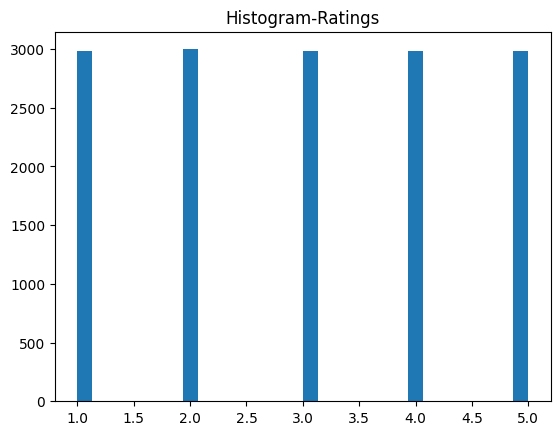

In [24]:
import matplotlib.pyplot as plt
#histogram of rating
plt.hist(balanced_df['Rating'],bins=30)
plt.title('Histogram-Ratings')
plt.show()

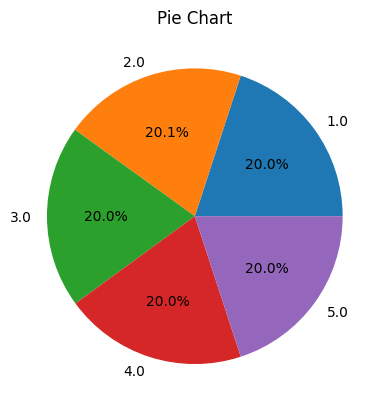

In [25]:
#pie chart
rating_counts = balanced_df['Rating'].value_counts().sort_index()
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%')
plt.title("Pie Chart")
plt.show()

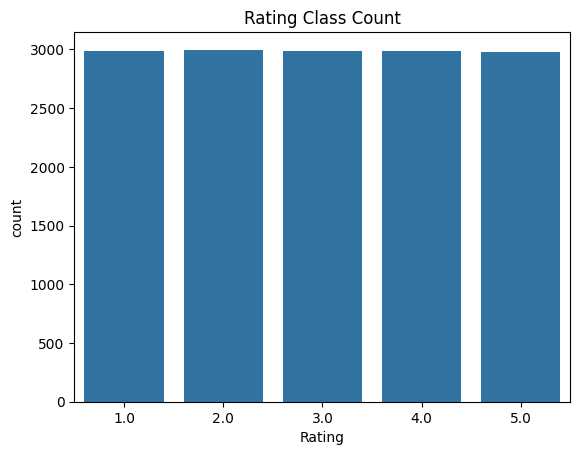

In [26]:
import seaborn as sns
#Count plot (for categorical data)
sns.countplot(x='Rating', data=balanced_df)
plt.title("Rating Class Count")
plt.show()